[View in Colaboratory](https://colab.research.google.com/github/vbipin/nlp/blob/master/pytorch_nmt_with_attn.ipynb)

In [2]:
!pip3 install torch

    100% |████████████████████████████████| 484.0MB 24kB/s 
tcmalloc: large alloc 1073750016 bytes == 0x5cef2000 @  0x7f99cb9b51c4 0x46d6a4 0x5fcbcc 0x4c494d 0x54f3c4 0x553aaf 0x54e4c8 0x54f4f6 0x553aaf 0x54efc1 0x54f24d 0x553aaf 0x54efc1 0x54f24d 0x553aaf 0x54efc1 0x54f24d 0x551ee0 0x54e4c8 0x54f4f6 0x553aaf 0x54efc1 0x54f24d 0x551ee0 0x54efc1 0x54f24d 0x551ee0 0x54e4c8 0x54f4f6 0x553aaf 0x54e4c8


In [7]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch import optim
import torch.nn.functional as F

use_cuda = torch.cuda.is_available()

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [0]:
#This notebook is adapted from
##http://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html

In [9]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
#for monitoring
from time import time
#for parsing the data filename
import re

In [ ]:
#here we prepare data directly form the web link. It is useful in Colab notebooks
#to convert to script
#jupyter nbconvert --to script [YOUR_NOTEBOOK].ipynb

In [4]:
#we need the data from : http://www.manythings.org/anki/fra-eng.zip
import requests
import gzip
import io
import zipfile

#get the contents from the website
r = requests.get('http://www.manythings.org/anki/fra-eng.zip')

#this is one ugly code; But I need the text from a zip file in a url :(((
#https://stackoverflow.com/questions/37704836/how-do-i-read-a-csv-file-thats-gzipped-from-url-python
#https://codeyarns.com/2013/10/03/how-to-read-contents-of-zip-file-in-python/
#https://docs.python.org/2/library/zipfile.html
with zipfile.ZipFile( io.BytesIO(r.content), mode='r' ) as zip_file :
  print (zip_file.namelist())
  lines = zip_file.read('fra.txt').strip().split(b'\n')
  lines = [ str(l, 'utf-8') for l in lines ]
  print(len(lines))

['_about.txt', 'fra.txt']
154883


In [ ]:
#if we have the lines form a file; create it here.

In [10]:
#This class is from the pytorch tutorial. 
#it holds thevocab and index convertions

#XXX TODO: May be use torchtext

SOS_token = 0
EOS_token = 1

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {"SOS" :0, "EOS" :1}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS
        self.SOS_token = 0
        self.EOS_token = 1
        self.word2count = {}

    def add_line(self, sentence):
        for word in sentence.split(' '):
            self.add_word(word)

    def add_word(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1
    

In [33]:
# Turn a Unicode string to plain ASCII, thanks to
# http://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters


def normalize_string(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)     #add a space
    s = re.sub(r"[^a-zA-Z.!?']+", r" ", s) #only these; others are spaces
    return s

In [68]:
import re
#m = re.search( '(...)-(...)\.txt', 'eng-fra.txt')
#m.group(2)
class Data :
    def __init__(self, filename, src, dest, reverse=False, n_data=-1 ) :
        #we do a small hack here to check for file name
        if isinstance(filename, list): #must be data coming in
          lines = filename
        else :
          lines = open(filename, encoding='utf-8').read().strip().split('\n')
          m = re.search( '(...)-(...)\.txt', filename)
          src, dest = m.group(1), m.group(2)
          
        lines=lines[0:n_data] #XXXX last pair is not included
        
                   
        # Split every line into pairs and normalize
        #self.pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]
        
        self.pairs = lines
        
        if reverse : #reverse src and dest
            dest, src = src, dest
            self.pairs = [ (s[1], s[0]) for s in self.pairs ] #reverse each pair
            
        self.src = Lang(src) #for each language counts etc
        self.dest = Lang(dest)
        
        for s,d in self.pairs :
            self.src.add_line(s)
            self.dest.add_line(d)
            
        #self.seq_len = 1
        self.batch_size = 1
        
        #to tensor
        #self.src_lines  = torch.stack( [ self.line_to_tensor(self.src,   s).view(-1,1 ) for s,d in self.pairs ] )
        #self.dest_lines = torch.stack( [ self.line_to_tensor(self.dest,  d).view(-1,1 ) for s,d in self.pairs ] )
        
        #self.tensor_pairs = [torch.Tensor(self.line_to_tensor(self.src,  s).view(-1,1 ), 
        #                                self.line_to_tensor(self.dest, d).view(-1,1 )) for s,d in self.pairs ] 
        #self.tensor_pairs = torch.stack( self.tensor_pairs ).to(device)
        
    def word_to_tensor(self, word, lang=None ) :
        if not lang :
            lang = self.dest
        return torch.LongTensor( [lang.word2index[word]] ).view(-1,1).to(device)
    
    def index_to_tensor(self, index) :
        return torch.LongTensor( [index] ).view(-1,1).to(device)
        
    def line_to_tensor(self, lang, sentence):
        idxs = [lang.word2index[word] for word in sentence.split(' ')]
        #idxs.append( lang.EOS_token ) # this is the EOS token
        idxs = [lang.SOS_token] + idxs + [lang.EOS_token]
        return torch.LongTensor(idxs)
            
    def batch_(self, n_data=1000, random=True) : #we return the torchtensor inputs to embedding layers
        N = len(self.pairs)
        r_indexs = np.random.randint(N, size=n_data)
        for i in r_indexs :
            st,dt = self.tensor_pairs[i] 
            yield st, dt
            #yield st.to(device), dt.to(device)
            
    def batch__(self, batch_size=1) : #we return the torchtensor inputs to embedding layers
        for s,d in self.pairs : 
            st = self.line_to_tensor(self.src,  s).view(-1,1 ) #seq_length, index (n,1)
            dt = self.line_to_tensor(self.dest, d).view(-1,1 )#batch need to be handled later
            yield st.to(device), dt.to(device)
    
    def batch(self, n_data=1000, random=True) : #we return the torchtensor inputs to embedding layers
        #first we create n_size random indexes for 0 to N
        N = len(self.pairs)
        r_indexs = np.random.randint(N, size=n_data)
        for i in r_indexs :
            s,d = self.pairs[i] 
            st = self.line_to_tensor(self.src,  s).view(-1,1 ) #seq_length, index (n,1)
            dt = self.line_to_tensor(self.dest, d).view(-1,1 )#batch need to be handled later
            yield st.to(device), dt.to(device)


In [35]:
lines_de = open("data/multi30k/val.de", encoding='utf-8').read().strip().split('\n')
lines_en = open("data/multi30k/val.en", encoding='utf-8').read().strip().split('\n')

In [36]:
lines = [ (normalize_string(lines_de[i]), normalize_string(lines_en[i])) for i in range(len(lines_de)) ]
len(lines)

1014

In [37]:
m, n = 0, 0
for i,j in lines :
    il = len(i.split(' '))
    jl = len(j.split(' '))
    if m < il :
        print(i)
        m = il
    if n < jl :
        n = jl

eine gruppe von mannern ladt baumwolle auf einen lastwagen
ein mann schlaft in einem grunen raum auf einem sofa .
ein mann mit beginnender glatze der eine rote rettungsweste tragt sitzt in einem kleinen boot .
eine frau in einem rotem mantel die eine vermutlich aus asien stammende handtasche in einem blauen farbton halt springt fur einen schnappschuss in die luft .
ein madchen sitzt in bequemer haltung an einem offentlichen ort und liest ein buch das sie mit ihrer hand geoffnet halt an der sich ein ring mit einem schmetterling befindet .
zwei menschen von denen der eine wie eine nonne gekleidet ist und der andere ein roger smith t shirt tragt rennen bei einem wettlauf in einem bewaldeten gebiet an zuschauern vorbei .


In [38]:
print(m,n)

32 29


In [69]:
#German to English
data = Data( lines, 'en', 'de', n_data=1000 )
print(random.choice(data.pairs))

('viele stuhle sind leer und nur einige wenige menschen genie en die sonne .', 'many of the chairs are empty with only a few people enjoying the sun .')


In [8]:
#French to English
#data = Data( lines, 'eng', 'fra', reverse=True, n_data=10000 )
#print(random.choice(data.pairs))

('faisons le .', "let's do it .")


In [ ]:
##################################################################

In [19]:
class EncoderRNN(nn.Module):
    def __init__(self, src_vocab_size, hidden_size, num_layers=1 ):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        
        #embedding vector size is fixed as hidden size
        self.enbedding_vector_size = hidden_size
        self.embedding = nn.Embedding(src_vocab_size, self.enbedding_vector_size )
        self.gru = nn.GRU(hidden_size, hidden_size, num_layers)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(-1)
        output = embedded.view( input.shape[0], 1, -1 ) #seq_length, batch, enbbding
        #print (output.shape)
        #print (hidden.shape)
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        result = Variable(torch.zeros(1, 1, self.hidden_size))
        if use_cuda:
            return result.cuda()
        else:
            return result

In [20]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, dest_vocab_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        
        #embedding vector size is fixed as hidden size
        self.enbedding_vector_size = hidden_size
        self.embedding = nn.Embedding(dest_vocab_size, self.enbedding_vector_size )
        
        self.gru = nn.GRU(hidden_size, hidden_size)
        
        self.linear = nn.Linear(hidden_size, dest_vocab_size)
        #self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(-1)
        #output = F.relu(output)
        output = embedded.view( input.shape[0], 1, -1 ) #input shape[0] is 1 as wqe feed one input at a time.
        
        output, hidden = self.gru(output, hidden)
        output = self.linear( output.squeeze() )
        #print (output.shape)
        output = F.log_softmax( output, dim=0 )
        return output.view(1,-1), hidden #output of shape N,C; here N=1

    def initHidden(self):
        result = Variable(torch.zeros(1, 1, self.hidden_size))
        if use_cuda:
            return result.cuda()
        else:
            return result

In [39]:
MAX_LENGTH = 35

class Attn(nn.Module) :
    def __init__(self, hidden_size, max_length) :
        super(Attn, self).__init__()
        self.hidden_size = hidden_size
        self.max_length = max_length
        self.linear = nn.Linear(self.hidden_size, self.max_length)
        
        
    def forward(self, hidden, encoder_outputs) :
        
        attn_scores = self.linear(hidden)
        #print("attn_scores", attn_scores.shape )
                
        attn_weights = F.softmax(attn_scores, dim=2)
        
        #print("attn_weights", attn_weights.shape)
        #print("encoder_outputs",encoder_outputs.shape)
        
        attn_applied = torch.matmul(attn_weights.squeeze(),encoder_outputs)
        #print ("attn_applied ", attn_applied.shape)
        
        return attn_applied, attn_weights
        
        
        
        
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length
        
        #embedding vector size is fixed as hidden size
        self.enbedding_vector_size = hidden_size

        self.embedding = nn.Embedding(self.output_size, self.enbedding_vector_size)
        
        self.attn = Attn(self.hidden_size, self.max_length)
        #self.attn = nn.Linear(self.hidden_size, self.max_length)        
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        #self.dropout = nn.Dropout(self.dropout_p)
        
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        """input is an index of the word. We create a word vector out of it"""
        embedded = self.embedding(input) 
        #print("embedded", embedded.shape )
                
        """ gru hidden has shape (num_layers * num_dir, batch, hidden_size)
            Here first two dim are 1
        """
        output, hidden = self.gru(embedded.view(1,1,-1), hidden)
        #print ("hidden ", hidden.shape)
        
        #linear W.h 
        #out (max, )
        attn_context, attn_weights = self.attn( hidden, encoder_outputs)
        #print ("attn_context ", attn_context.shape)
        
        
        output = torch.cat((hidden.view(1,-1), attn_context.view(1,-1)), 1)
        #print ("output ", output.shape) 
        
        output = self.attn_combine(output)
        #print ("output ", output.shape)        
        output = F.relu(output) #h tilde
        #print ("output ", output.shape)
        
        #output = F.log_softmax(self.out(output), dim=1)
        output = self.out(output)
        #print ("output ", output.shape)
        
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [40]:
#debug_list = []
def translate( encoder, decoder, data, input_sentence ) :
    debug_list = [] #XXX
    x = data.line_to_tensor( data.src, input_sentence ).to(device)
    h = encoder.initHidden().to(device)
    out, h = encoder(x, h)
    g = h
    
    encoder_outputs = torch.zeros(MAX_LENGTH, encoder.hidden_size, device=device)
    for i in range(out.shape[0]) :
        encoder_outputs[i] = out[i][0]
        
    #first input is SOS
    next_word = data.index_to_tensor( data.dest.SOS_token ).to(device)
    predicted_target = []
    for _ in range(25) :        
        scores, g, attn_w = decoder( next_word, g, encoder_outputs )
        #debug_list.append(attn_w)
        if next_word.item() == data.dest.EOS_token :
            break
        predicted_target.append( next_word.item() )
        #now we make the next_word from current_word
        v, next_word = scores.topk(1) #return value and index
        #new_word = data.index_to_tensor( next_word )
        #next_word = torch.multinomial( torch.exp(scores), 1 )[0]
        #next_word = torch.multinomial( scores, 1 )[0]
        
        
    return " ".join([ data.dest.index2word[i] for i in predicted_target ])

In [41]:
MAX_LENGTH = 35
def train(encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, n_data=1000 ) :
    start = time()
    batch = data.batch(n_data=n_data, random=True)
    
    loss_db = []
    for x, y in batch :
        loss = 0
        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()
        
        h = encoder.initHidden().to(device)
        h.detach_()

        out, h = encoder(x, h)
        g = h

        encoder_outputs = torch.zeros(MAX_LENGTH, encoder.hidden_size, device=device)
        for i in range(out.shape[0]) :
            encoder_outputs[i] = out[i][0]
    
        for i in range(len(y) - 1) :
        #for i in range(1) :
            scores, g, attn_w = decoder( y[i], g, encoder_outputs )
            #print(scores.shape)
            #print(next_word.shape)
            
            loss += criterion(scores, y[i+1] )
            #next_word = sample_from_scores( scores )  
            #next_word = sample_from_softmax( scores )

            #next_word = data.index_to_tensor( next_word )

        loss.backward()
        loss_db.append( float(loss) )
        
        decoder_optimizer.step()
        encoder_optimizer.step()
        if n_data < 0 :
            break
        else :
            n_data -= 1
        
    end = time()
    print (end-start)
    return loss_db

In [42]:
hidden_size = 256
encoder = EncoderRNN(data.src.n_words, hidden_size).to(device)
decoder = AttnDecoderRNN(hidden_size, data.dest.n_words).to(device)

print(encoder)
print(decoder)



EncoderRNN(
  (embedding): Embedding(2704, 256)
  (gru): GRU(256, 256)
)
AttnDecoderRNN(
  (embedding): Embedding(2373, 256)
  (attn): Attn(
    (linear): Linear(in_features=256, out_features=35, bias=True)
  )
  (attn_combine): Linear(in_features=512, out_features=256, bias=True)
  (gru): GRU(256, 256)
  (out): Linear(in_features=256, out_features=2373, bias=True)
)


In [43]:
learning_rate = 0.0001
encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
#criterion = nn.NLLLoss().to(device)
criterion = nn.CrossEntropyLoss().to(device)

In [70]:
avg_loss = []
for _ in range(1) :
    l = train(encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, n_data=1000 )
    avg_loss.append( np.mean(l))

40.90017557144165


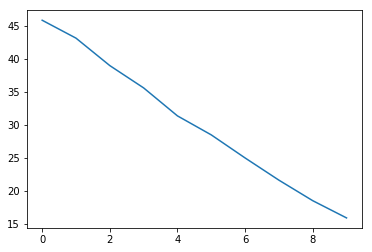

In [53]:
plt.plot(avg_loss)

In [54]:
i = 988
input_sentence  = data.pairs[i][0]
output_sentence = translate( encoder, decoder, data, input_sentence )
print(data.pairs[i])
print(output_sentence)

('ein kieferorthopade arbeitet an einem patienten wahrend ein mann die lampe halt .', 'an orthodontist working on a patient while a man holds the light .')
SOS a sleeping car truck room unusual is still truck roller dusk is work
